# Models comparison

Prerequisite: train the models you want to evaluate. Run > `python train.py --model <model_name>`


In [15]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

from sklearn import metrics
from scipy.stats import entropy

import ujson as json

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# set default size to display larger figures
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [16]:
# to import from parent directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [17]:
# import models to compare
from ML_models import NaiveBayes

## Models comparison script

It computes the following metrics:
- overall accuracy
- f1-score: computed globally by counting the total true positives, false negatives and false positives
- mean absolute error (MAE)
- KL-divergence (with logarithm base of 10): divergence of P from Q

It plots:
- confusion matrix
- predicted class distribution

References:
- f1-score in sklearn.metrics: [how is it computed?](https://datascience.stackexchange.com/questions/40900/whats-the-difference-between-sklearn-f1-score-micro-and-weighted-for-a-mult)

In [215]:
# ADAPTED FROM: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

def highlight_best(data, best_direction={}, best_color='green', worst_color='red'):
    '''Highlight the best and worst column values in a DataFrame
    
    Args:
        'data' (pd.Series or pd.DataFrame): dataset
        'best_direction' (dict: String -> bool): indicate whether a maximum (True) or a minimum (False) is the best column value
        'color' (String): color of the highlight
    
    Return:
        'style_mask' (list or pd.Dataframe): dataset with best column values highlighted
    
    Remark:
        If used with '.apply(axis=0)': the mask is computed column per column, 'data' is a pd.Series and 'style_mask' is a list
        If used with '.apply(axis=None)': the mask is on the whole pd.DataFrame 'data' and 'style_mask' is a pd.DataFrame
    '''
    best_attr = "background-color: {}".format(best_color)
    worst_attr = "background-color: {}".format(worst_color)
        
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        is_min = data == data.min()
        style_mask = [(ismax[i]*best_attr) + (ismin[i]*best_attr) + ""]
    
    else:  # from .apply(axis=None)
        best = [np.max(data[column_name]) if best_direction.get(column_name, True) else np.min(data[column_name]) for column_name in data.columns]
        is_best = data.eq(best)
        
        worst = [np.min(data[column_name]) if best_direction.get(column_name, True) else np.max(data[column_name]) for column_name in data.columns]
        is_worst = data.eq(worst)
        
        style_mask = pd.DataFrame(np.core.defchararray.add(np.where(is_best, best_attr, ""), np.where(is_worst, worst_attr, "")), index=data.index, columns=data.columns)
        
    return style_mask

In [254]:
def class_distribution(y_pred_list, fig_legend, grade2class):
    """Plot an histogram of the class distribution from the model(s)
    """        
    # input type cleanup to match expected type
    if not isinstance(y_pred_list, list):
        y_pred_list = [y_pred_list]
        
    # class distribution
    class_min = min(grade2class.values())
    class_max = max(grade2class.values())
    
    # plot histogram
    plt.hist(y_pred_list, bins = range(class_min, class_max+2), density=True, histtype='bar')
    plt.legend(fig_legend)
    plt.xticks(list(grade2class.values()), list(grade2class.keys()))
    plt.xlabel("Grade")
    plt.ylabel("Frequency")
    plt.title("Class distribution")
    plt.show()
    # print class distribution
    for k, subset_name in enumerate(fig_legend):
        y_pred_filtered = y_pred_list[k][y_pred_list[k] != -1]
        grade2freq = {grade: round(y_pred_filtered[y_pred_filtered==grade2class[grade]].shape[0]/y_pred_filtered.shape[0]*100, 1) for grade in grade2class.keys()}
        print("Distribution of classes in {} :\n{}".format(subset_name, grade2freq))

In [312]:
def models_comparison(models_dict, X, y, grade2class, y_user=None):
    
    # input type cleanup to match expected type
    if isinstance(models_dict, list):
        models_dict = {"model " + str(i): model for i, model in enumerate(models_dict)}
    elif not isinstance(models_dict, dict):
        models_dict = {"your model": models_dict}
    
    # metrics of interest
    metrics_dict = {"Accuracy": True, "MAE":False, "F1-score":True, "KL_divergence":False}
    
    # true class distribution
    p_true = [np.sum(y == c)/y.shape[0] for c in grade2class.values()]
    
    models_pred = {}
    models_distribution = {}
    for model_name in models_dict.keys():
        # class prediction
        y_pred = models_dict[model_name].predict(X)
        models_pred[model_name] = y_pred
        # predicted class distribution
        p_pred = [np.sum(y_pred == c)/y.shape[0] for c in grade2class.values()]
        models_distribution[model_name] = p_pred
    
    # table summarizing the metrics for each model
    metrics_table = pd.DataFrame(data={"Accuracy": [metrics.accuracy_score(y, y_pred) for y_pred in models_pred.values()],
                           "F1-score": [metrics.f1_score(y, y_pred, average='micro') for y_pred in models_pred.values()],
                           "MAE": [metrics.mean_absolute_error(y, y_pred) for y_pred in models_pred.values()],
                            "KL_divergence": [entropy(p_pred, p_true, base=10) for p_pred in models_distribution.values()]},
                          index=models_pred.keys())
    metrics_table = metrics_table[list(metrics_dict.keys())]    
        
    # sort in decreasing accuracy score
    #metrics_table.sort_values(by=["Accuracy", "F1-score", "MAE", "KL_divergence"], axis=0, ascending=False, inplace=True)

    # highlights the best values
    display(metrics_table.style.apply(lambda data: highlight_best(data, best_direction=metrics_dict), axis=None).format("{:.2f}"))

    # user assigned grades
    if not y_user is None:
        user_label = "user assigned grades"
        # filter examples with user assigned grades
        y_filtered = y[y_user != -1]
        y_user_filtered = y_user[y_user != -1]
        # user class distribution
        p_user = [np.sum(y_user_filtered == c)/y_filtered.shape[0] for c in grade2class.values()]
        # metrics
        user_metrics = {"Accuracy": metrics.accuracy_score(y_filtered, y_user_filtered),
                        "F1-score": metrics.f1_score(y_filtered, y_user_filtered, average='micro'),
                        "MAE": metrics.mean_absolute_error(y_filtered, y_user_filtered),
                        "KL_divergence": entropy(p_user, p_true, base=10)}
        print("User assigned grades metrics: \n", user_metrics)
    
    # plot the class distribution of the best model
    best_model_name = metrics_table['Accuracy'].argmax()
    
    # plot the class distribution of the vanilla model
    vanilla_name_list = [key for key in models_dict.keys() if "vanilla" in key]
    if len(vanilla_name_list) > 0:
        y_pred_list = [y, models_pred[vanilla_name_list[0]], models_pred[best_model_name]]
        fig_legend = ["True class distribution", vanilla_name_list[0], best_model_name]
    else:
        y_pred_list = [y, models_pred[best_model_name]]
        fig_legend = ["true class distribution", best_model_name]
    if not y_user is None:
        y_pred_list.append(y_user)
        fig_legend.append(user_label)
    
    class_distribution(y_pred_list, fig_legend, grade2class)


## Naive Bayes tuning

Tune the weighting scheme on the validation set.

To account for imbalance, each example $x^{(i)}$ is reweighted according to the class $y^{(i)}$ it belongs to:

$w(x^{(i)}) = \frac{1}{p^{y^{(i)}}}$

Where: $p^{y^{(i)}}$ is the fraction of training examples that are in class $y^{(i)}$.
(Or equivalently, the fraction of validation examples, as the split was done in order to preserve the class distribution in each set).

In [313]:
def NB_tuning(MBversion=2016, ppDirName="../data/binary"):
    MBversion = str(MBversion)
    print("{:-^100}".format("Naive Bayes weighting scheme tuning, on MoonBoard version {}".format(MBversion)))
    
    # path to the data
    ppVersionDirName = os.path.join(ppDirName, MBversion)
    # import the data
    X_val = np.load(os.path.join(ppVersionDirName, "X_val.npy"))
    y_val = np.load(os.path.join(ppVersionDirName, "y_val.npy"))
    y_user_val = np.load(os.path.join(ppVersionDirName, "y_user_val.npy"))
    with open(os.path.join(ppVersionDirName, "grade2class.json")) as json_file:  
        grade2class = json.load(json_file)
    
    # true class distribution
    p_true = {c: np.sum(y_val == c)/y_val.shape[0] for c in set(y_val)}
    
    # weighting parameter to tune
    k_list = range(1, 10)
    # create the models
    models_dict = {"NB with HP k="+str(k): NaiveBayes(weights={c: 1./p**k for c, p in p_true.items()}) for k in k_list}
    models_dict["vanilla NB (k=0)"] = NaiveBayes()

    # train the models
    for model in models_dict.values():
        model.fit(X_val, y_val)
    
    # compare the models
    models_comparison(models_dict, X_val, y_val, grade2class, y_user=y_user_val)
    

-------------------Naive Bayes weighting scheme tuning, on MoonBoard version 2016-------------------


,Accuracy,MAE,F1-score,KL_divergence
NB with HP k=1,0.33,2.22,0.33,0.38
NB with HP k=2,0.34,2.09,0.34,0.32
NB with HP k=3,0.36,1.90,0.36,0.26
NB with HP k=4,0.39,1.75,0.39,0.20
NB with HP k=5,0.38,2.33,0.38,0.39
NB with HP k=6,0.29,4.22,0.29,1.03
NB with HP k=7,0.18,6.20,0.18,1.70
NB with HP k=8,0.11,7.37,0.11,2.09
NB with HP k=9,0.06,8.05,0.06,2.32
vanilla NB (k=0),0.33,2.31,0.33,0.42


User assigned grades metrics: 
 {'Accuracy': 0.9734675205855444, 'F1-score': 0.9734675205855444, 'MAE': 0.04117108874656908, 'KL_divergence': 0.048764358332762305}


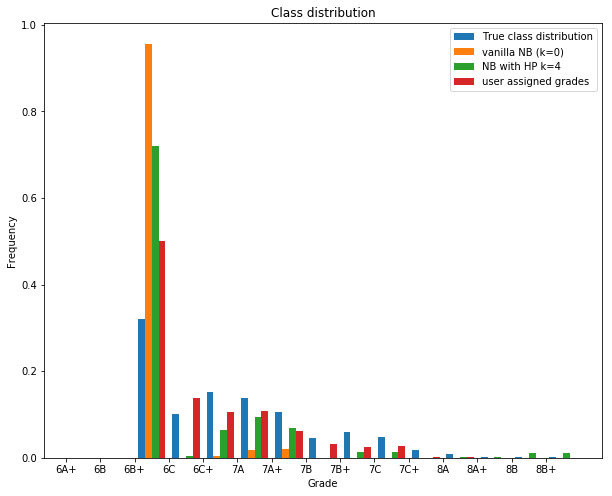

Distribution of classes in True class distribution :
{'6A+': 0.0, '6B': 0.0, '6B+': 32.0, '6C': 10.1, '6C+': 15.1, '7A': 13.8, '7A+': 10.5, '7B': 4.6, '7B+': 6.1, '7C': 4.8, '7C+': 1.7, '8A': 0.8, '8A+': 0.3, '8B': 0.1, '8B+': 0.1}
Distribution of classes in vanilla NB (k=0) :
{'6A+': 0.0, '6B': 0.0, '6B+': 95.6, '6C': 0.0, '6C+': 0.5, '7A': 1.9, '7A+': 2.0, '7B': 0.0, '7B+': 0.0, '7C': 0.0, '7C+': 0.0, '8A': 0.0, '8A+': 0.0, '8B': 0.0, '8B+': 0.0}
Distribution of classes in NB with HP k=4 :
{'6A+': 0.0, '6B': 0.0, '6B+': 71.9, '6C': 0.4, '6C+': 6.4, '7A': 9.4, '7A+': 6.9, '7B': 0.0, '7B+': 1.2, '7C': 1.4, '7C+': 0.0, '8A': 0.1, '8A+': 0.1, '8B': 1.1, '8B+': 1.1}
Distribution of classes in user assigned grades :
{'6A+': 0.0, '6B': 0.0, '6B+': 50.0, '6C': 13.7, '6C+': 10.5, '7A': 10.7, '7A+': 6.2, '7B': 3.2, '7B+': 2.6, '7C': 2.7, '7C+': 0.3, '8A': 0.1, '8A+': 0.0, '8B': 0.0, '8B+': 0.0}


In [314]:
NB_tuning()